# 전자제품 판매 쇼핑몰 회사의 데이터 분석

## 기본 설정

In [1]:
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

Reading package lists... Done
Building dependency tree       
Reading state information... Done
fonts-nanum is already the newest version (20170925-1).
0 upgraded, 0 newly installed, 0 to remove and 40 not upgraded.
/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 3 dirs
/usr/share/fonts/truetype/humor-sans: caching, new cache contents: 1 fonts, 0 dirs
/usr/share/fonts/truetype/liberation: caching, new cache contents: 16 fonts, 0 dirs
/usr/share/fonts/truetype/nanum: caching, new cache contents: 10 fonts, 0 dirs
/usr/local/share/fonts: caching, new cache contents: 0 fonts, 0 dirs
/root/.local/share/fonts: skipping, no such directory
/root/.fonts: skipping, no such directory
/var/cache/fontconfig: cleaning cache directory
/root/.cache/fontconfig: not cleaning non-existent cache directory
/root/.fontconfig: not cleaning non-existent cache directory
fc-cache: succeeded


In [2]:
import matplotlib.pyplot as plt
plt.rc('font', family='NanumBarunGothic')

In [3]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [4]:
DRIVE_PATH = "/content/drive/MyDrive/2022년 멀티캠퍼스 빅데이터 강좌/05. Data Analyze/04_서비스 건강성 분석하기/event_log.csv"

In [5]:
import pandas as pd
import seaborn as sns
import matplotlib.ticker as ticker

## 데이터 불러오기

In [6]:
df = pd.read_csv(DRIVE_PATH)
df.head()

,event_time,event_type,product_id,category_id,category_code,brand,price,user_id,user_session
0,2020-09-24 11:57:06 UTC,view,1996170,2144415922528452715,electronics.telephone,NaN,31.90,1515915625519388267,LJuJVLEjPT
1,2020-09-24 11:57:26 UTC,view,139905,2144415926932472027,computers.components.cooler,zalman,17.16,1515915625519380411,tdicluNnRY
2,2020-09-24 11:57:27 UTC,view,215454,2144415927158964449,NaN,NaN,9.81,1515915625513238515,4TMArHtXQy
3,2020-09-24 11:57:33 UTC,view,635807,2144415923107266682,computers.peripherals.printer,pantum,113.81,1515915625519014356,aGFYrNgC08
4,2020-09-24 11:57:36 UTC,view,3658723,2144415921169498184,NaN,cameronsino,15.87,1515915625510743344,aa4mmk0kwQ


### 컬럼 설명
- event_time: 이벤트가 일어난 시간 (UTC: 국제 표준시)
- event_type: view(상품 보기), cart(장바구니 담기), remove_from_cart(장바구니에서 제거하기), purchase (구매하기)
- product_id: 상품 ID
- category_id: 카테고리 ID
- category_code: 카테고리 코드 이름
- brand: 브랜드 이름
- price: 상품의 가격
- user_id: 유저 아이디
- user_session: 유저 세션 아이디 

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 885129 entries, 0 to 885128
Data columns (total 9 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   event_time     885129 non-null  object 
 1   event_type     885129 non-null  object 
 2   product_id     885129 non-null  int64  
 3   category_id    885129 non-null  int64  
 4   category_code  648910 non-null  object 
 5   brand          672765 non-null  object 
 6   price          885129 non-null  float64
 7   user_id        885129 non-null  int64  
 8   user_session   884964 non-null  object 
dtypes: float64(1), int64(3), object(5)
memory usage: 60.8+ MB


In [8]:
df[['price']].describe()

,price
count,885129.000000
mean,146.328713
std,296.807683
min,0.220000
25%,26.460000
50%,65.710000
75%,190.490000
max,64771.060000


평균과 중앙값의 차이가 있는 것을 알 수 있다. 평균보다 중앙값이 훨씬 작기 때문에 상품들 중에 굉장히 비싼 가격의 상품이 있다는 것을 예측할 수 있다.

# 유저 행동 데이터 알아보기

단순히 가입된 유저가 많다고 무조건 좋은 서비스는 아니다.
- 활동하는 유저(Active User)가 많이 없으면 건강한 서비스는 아닐 것이다.
- 사용자가 활발하게 평소에도 자주 쓰는 서비스가 건강한 서비스가 될 수 있다.

## Active User

Active User는 특정 기간 안에 서비스를 방문한 유니크한 사용자의 수

**장점**
- 거의 모든 서비스에서 쉽게 구할 수 있다.
- 자주 사용되는 지표

**단점**
- 사용자의 Unique한 방문만 보기 때문에 서비스 내에 유저가 들어와서 얼마나 활발하게 활동하는지는 모름
- 서비스에 들어와서 구매로 전환은 되는지 등은 알기 힘들다.

**Daily Active User(DAU)**
- 하루 동안(24시간) 방문한 Unique한 유저의 수

**Weekly Active User(WAU)**
- 일주일(7일) 동안 방문한 Unique한 유저의 수

**Monthly Active Use(MAU)**
- 한 달(30일) 동안 방문한 Unique한 유저의 수

# Daily Active User (기간: 매일)

In [9]:
df['event_date'] = df['event_time'].str[:10]
df['event_date_dtm_format'] = pd.to_datetime(df['event_date'])

df = df.loc[df['event_date'] > '2020-09-30']
df.head()

,event_time,event_type,product_id,category_id,category_code,brand,price,user_id,user_session,event_date,event_date_dtm_format
28074,2020-10-01 00:01:36 UTC,view,1795171,2144415922360680550,computers.peripherals.camera,canyon,39.75,1515915625520113390,4X2NwIInsI,2020-10-01,2020-10-01
28075,2020-10-01 00:04:11 UTC,view,1549819,2144415925011480748,stationery.cartrige,xerox,69.35,1515915625521278799,daM8ubpOfo,2020-10-01,2020-10-01
28076,2020-10-01 00:07:23 UTC,view,4156248,2144415921169498184,NaN,NaN,17.14,1515915625521278938,EdgYsorbdC,2020-10-01,2020-10-01
28077,2020-10-01 00:07:56 UTC,view,16101,2144415922360680550,computers.peripherals.camera,NaN,30.38,1515915625520113390,4X2NwIInsI,2020-10-01,2020-10-01
28078,2020-10-01 00:08:11 UTC,view,880508,2144415926806642904,computers.components.power_supply,cougar,57.13,1515915625521279091,Et4GWStGMB,2020-10-01,2020-10-01


In [10]:
# nunique를 이용해 중복되지 않은 카운트 세기
# 날짜별 unique user 수 계산

dau_data = df.groupby("event_date")[["user_id"]].nunique().reset_index()
dau_data

,event_date,user_id
0,2020-10-01,2699
1,2020-10-02,2559
2,2020-10-03,2162
3,2020-10-04,2398
4,2020-10-05,2832
...,...,...
146,2021-02-24,2904
147,2021-02-25,2784
148,2021-02-26,2960
149,2021-02-27,2578


In [11]:
dau_data = dau_data.rename(columns={"user_id":"user_count"})
dau_data.head()

,event_date,user_count
0,2020-10-01,2699
1,2020-10-02,2559
2,2020-10-03,2162
3,2020-10-04,2398
4,2020-10-05,2832


In [12]:
dau_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 151 entries, 0 to 150
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   event_date  151 non-null    object
 1   user_count  151 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 2.5+ KB


In [13]:
dau_data.describe()

,user_count
count,151.000000
mean,2984.854305
std,472.763921
min,1370.000000
25%,2683.500000
50%,2943.000000
75%,3308.500000
max,4287.000000


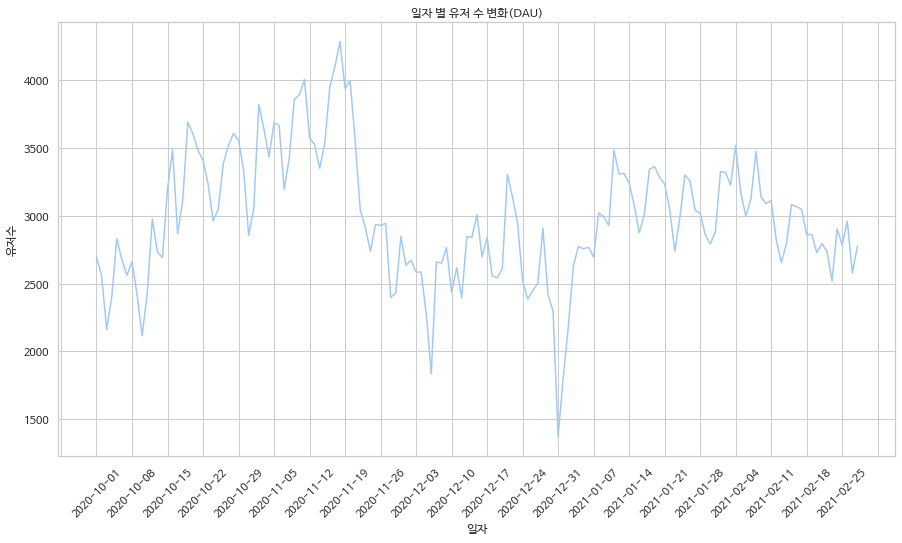

In [14]:
sns.set_theme(style="whitegrid", palette="pastel")
plt.rc('font', family='NanumBarunGothic')
plt.xticks(rotation=45)

g = sns.lineplot(x="event_date", y="user_count", data=dau_data)
g.figure.set_size_inches(15, 8)

# 축의 간격을 7배로 설정
g.xaxis.set_major_locator(ticker.MultipleLocator(7))

g.set_title("일자 별 유저 수 변화(DAU)")
g.set_xlabel("일자")
g.set_ylabel("유저수")

plt.show()

# Weekly Active User (기간: Weekly)

In [15]:
df["year_week_number"] = df["event_date_dtm_format"].dt.strftime("%Y-w%U")
df["year_week_number"]

28074     2020-w39
28075     2020-w39
28076     2020-w39
28077     2020-w39
28078     2020-w39
            ...   
885124    2021-w09
885125    2021-w09
885126    2021-w09
885127    2021-w09
885128    2021-w09
Name: year_week_number, Length: 857055, dtype: object

In [16]:
df2 = df.groupby("year_week_number")[["user_id"]].nunique().reset_index()
df2

,year_week_number,user_id
0,2020-w39,7141
1,2020-w40,16633
2,2020-w41,19305
3,2020-w42,22179
4,2020-w43,21956
5,2020-w44,23126
6,2020-w45,24038
7,2020-w46,25600
8,2020-w47,18586
9,2020-w48,16773


In [17]:
wau_data = df2.rename(columns={"user_id": "user_count"})
wau_data.head()

,year_week_number,user_count
0,2020-w39,7141
1,2020-w40,16633
2,2020-w41,19305
3,2020-w42,22179
4,2020-w43,21956


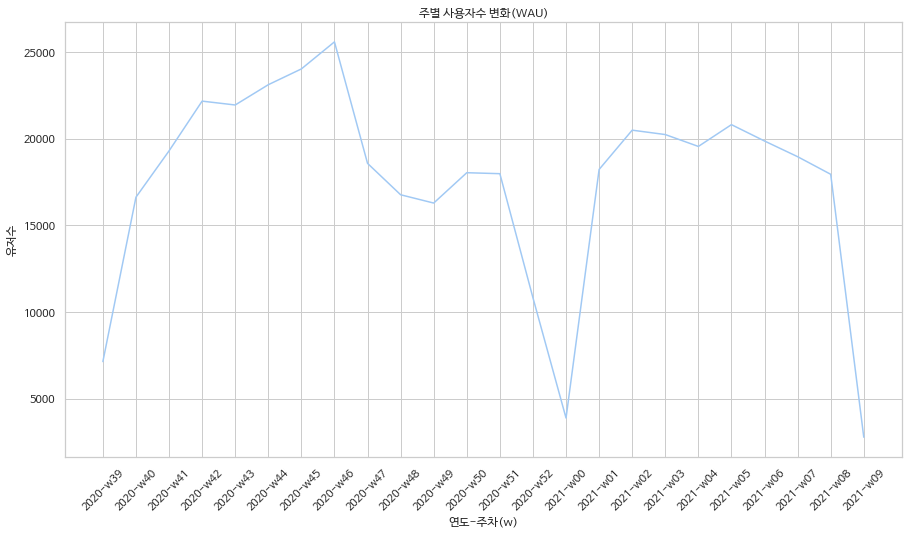

In [18]:
sns.set_theme( style="whitegrid", palette="pastel" )
plt.rc('font', family='NanumBarunGothic')
plt.xticks(rotation=45)

g = sns.lineplot(x="year_week_number", y="user_count", data=wau_data)
g.figure.set_size_inches(15, 8)

g.set_title("주별 사용자수 변화(WAU)")

g.set_xlabel("연도-주차(w)")
g.set_ylabel("유저수")

plt.show()

In [19]:
df3 = df.groupby("year_week_number")["event_date"].nunique()
df3

year_week_number
2020-w39    3
2020-w40    7
2020-w41    7
2020-w42    7
2020-w43    7
2020-w44    7
2020-w45    7
2020-w46    7
2020-w47    7
2020-w48    7
2020-w49    7
2020-w50    7
2020-w51    7
2020-w52    5
2021-w00    2
2021-w01    7
2021-w02    7
2021-w03    7
2021-w04    7
2021-w05    7
2021-w06    7
2021-w07    7
2021-w08    7
2021-w09    1
Name: event_date, dtype: int64

In [20]:
OLD_YEAR_WEEK_NUMBER = "2021-w00"
NEW_YEAR_WEEK_NUMBER = "2020-w52"

df.loc[df["year_week_number"]==OLD_YEAR_WEEK_NUMBER, "year_week_number"] = NEW_YEAR_WEEK_NUMBER
df_count_under_7 = df.loc[df["year_week_number"] != "2020-w39", :]
df_count_under_7 = df_count_under_7.loc[df["year_week_number"] != "2021-w09", :]

df_count_under_7.tail()

,event_time,event_type,product_id,category_id,category_code,brand,price,user_id,user_session,event_date,event_date_dtm_format,year_week_number
879856,2021-02-27 23:54:18 UTC,view,3605626,2144415927284793573,computers.components.tv_tuner,NaN,135.60,1515915625610575761,4cdLnsrdN7,2021-02-27,2021-02-27,2021-w08
879857,2021-02-27 23:54:40 UTC,purchase,1282166,2144415973346640379,computers.components.hdd,samsung,60.54,1515915625596223978,23rgL9Smqy,2021-02-27,2021-02-27,2021-w08
879858,2021-02-27 23:55:01 UTC,view,3791403,2144415926966026460,computers.components.cpu,amd,236.97,1515915625610075250,jIBEdIH8sd,2021-02-27,2021-02-27,2021-w08
879859,2021-02-27 23:55:05 UTC,view,3632668,2144415922528452715,electronics.telephone,NaN,34.44,1515915625610460876,ZU12Xy1KMK,2021-02-27,2021-02-27,2021-w08
879860,2021-02-27 23:57:55 UTC,view,1735131,2144415923107266682,computers.peripherals.printer,epson,210.19,1515915625610584639,AAtnTNcUPW,2021-02-27,2021-02-27,2021-w08


In [21]:
df_group_by_week_number = df_count_under_7.groupby("year_week_number")["user_id"].nunique()

wau_data = df_group_by_week_number.to_frame().reset_index().rename(columns={"user_id":"user_count"})
wau_data.head()

,year_week_number,user_count
0,2020-w40,16633
1,2020-w41,19305
2,2020-w42,22179
3,2020-w43,21956
4,2020-w44,23126


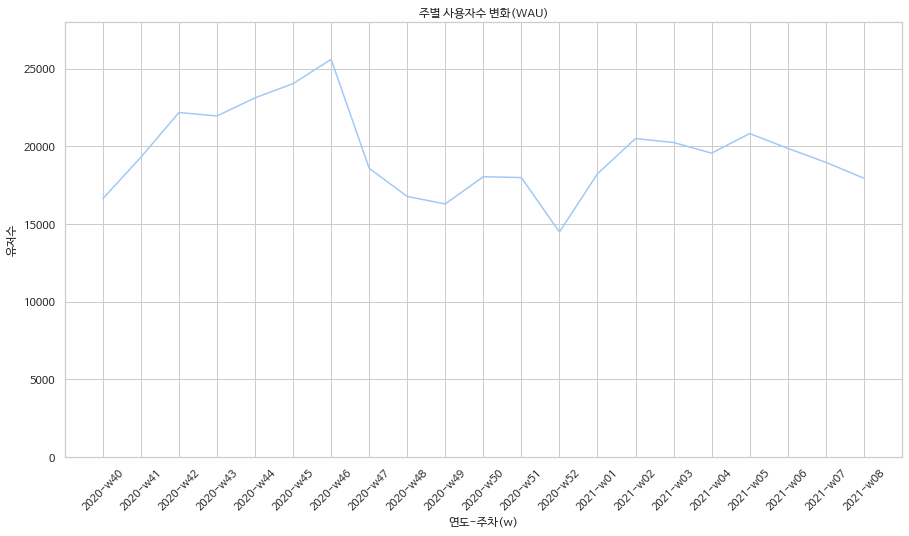

In [22]:
sns.set_theme( style="whitegrid", palette="pastel" )
plt.rc('font', family='NanumBarunGothic')
plt.xticks(rotation=45)

g = sns.lineplot(x="year_week_number", y="user_count", data=wau_data)
g.figure.set_size_inches(15, 8)

g.set_title("주별 사용자수 변화(WAU)")

g.set_xlabel("연도-주차(w)")
g.set_ylabel("유저수")

g.set_ylim(0, 28000)

plt.show()

# Monthly Active User (MAU)

In [23]:
df['event_month'] = df["event_time"].str[:7]
df['event_month'].head()

28074    2020-10
28075    2020-10
28076    2020-10
28077    2020-10
28078    2020-10
Name: event_month, dtype: object

In [24]:
mau_data = df.groupby("event_month")["user_id"].nunique().to_frame().reset_index().rename(columns={"user_id": "user_count"})
mau_data.head()

,event_month,user_count
0,2020-10,84216
1,2020-11,92600
2,2020-12,72137
3,2021-01,81256
4,2021-02,74606


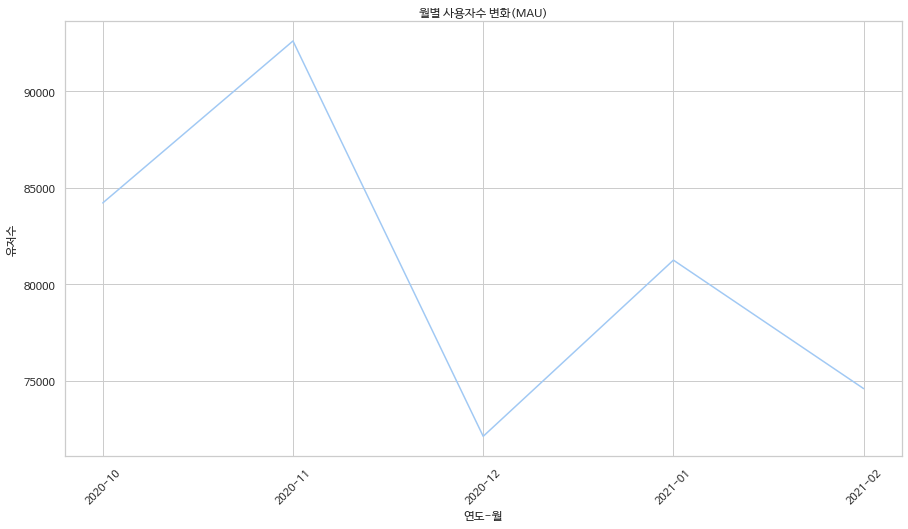

In [25]:
sns.set_theme( style="whitegrid", palette="pastel" )
plt.rc('font', family='NanumBarunGothic')
plt.xticks(rotation=45)

g = sns.lineplot(x="event_month", y="user_count", data=mau_data)
g.figure.set_size_inches(15, 8)

g.set_title("월별 사용자수 변화(MAU)")

g.set_xlabel("연도-월")
g.set_ylabel("유저수")

plt.show()

## DAU / MAU 
한 유저가 1달에 얼마나 자주 들어오는 서비스인지 판단할 수 있는 지표

In [26]:
avg_daily_user = dau_data['user_count'].mean()
avg_monthly_user = mau_data['user_count'].mean()

dau_mau_ration = avg_daily_user / avg_monthly_user
print(dau_mau_ration)

0.03686689357651966


# 유저수와 세션수

## 세션의 기준
- 브라우저
- 모바일

## 페이지 뷰의 기준
  - 화면이 전환되는 것을 기준으로 페이지 뷰 수를 더한다.
  > 뉴스 목록(+1) - 연예 기사 클릭(+1) - 다음 뉴스 클릭(+1) = 3

## 클릭 수
  - 같은 페이지 내에서도 유저가 마우스를 클릭하거나, 드래그를 하거나, 터치 횟수를 더한다.
  > 뉴스 목록 페이지에서 경제 기사를 3개씩 볼 수 있다! 뉴스 목록 페이지의 클릭수는 3

## 기타
  - 스크롤을 내리는 위치, 페이지에 체류하는 시간 등을 관심도의 지표로 활용할 수 있다.

In [27]:
df.head()

,event_time,event_type,product_id,category_id,category_code,brand,price,user_id,user_session,event_date,event_date_dtm_format,year_week_number,event_month
28074,2020-10-01 00:01:36 UTC,view,1795171,2144415922360680550,computers.peripherals.camera,canyon,39.75,1515915625520113390,4X2NwIInsI,2020-10-01,2020-10-01,2020-w39,2020-10
28075,2020-10-01 00:04:11 UTC,view,1549819,2144415925011480748,stationery.cartrige,xerox,69.35,1515915625521278799,daM8ubpOfo,2020-10-01,2020-10-01,2020-w39,2020-10
28076,2020-10-01 00:07:23 UTC,view,4156248,2144415921169498184,NaN,NaN,17.14,1515915625521278938,EdgYsorbdC,2020-10-01,2020-10-01,2020-w39,2020-10
28077,2020-10-01 00:07:56 UTC,view,16101,2144415922360680550,computers.peripherals.camera,NaN,30.38,1515915625520113390,4X2NwIInsI,2020-10-01,2020-10-01,2020-w39,2020-10
28078,2020-10-01 00:08:11 UTC,view,880508,2144415926806642904,computers.components.power_supply,cougar,57.13,1515915625521279091,Et4GWStGMB,2020-10-01,2020-10-01,2020-w39,2020-10


In [28]:
df_unique_user_and_session = df.loc[:, ["user_id", "user_session", "event_time", "event_date"]]

df_unique_user_and_session = df_unique_user_and_session.groupby("event_date").agg(["nunique", "count"])
df_unique_user_and_session.head()

user_id       user_session       event_time      
           nunique count      nunique count    nunique count
event_date                                                  
2020-10-01    2699  4657         2847  4654       4500  4657
2020-10-02    2559  4555         2728  4554       4397  4555
2020-10-03    2162  3774         2271  3774       3666  3774
2020-10-04    2398  4413         2529  4413       4231  4413
2020-10-05    2832  4982         3002  4981       4790  4982

In [29]:
df_unique_user_and_session.columns

MultiIndex([(     'user_id', 'nunique'),
            (     'user_id',   'count'),
            ('user_session', 'nunique'),
            ('user_session',   'count'),
            (  'event_time', 'nunique'),
            (  'event_time',   'count')],
           )

In [30]:
agg = df_unique_user_and_session.sort_values(by='event_date')

user_session_agg_df = pd.DataFrame(
    {
        "user_count": agg[(     'user_id', 'nunique')],
        "session_count": agg[('user_session', 'nunique')],
        "event_count": agg[(  'event_time',   'count')]
    }
)

user_session_agg_df.head()

,user_count,session_count,event_count
event_date,,,
2020-10-01,2699,2847,4657
2020-10-02,2559,2728,4555
2020-10-03,2162,2271,3774
2020-10-04,2398,2529,4413
2020-10-05,2832,3002,4982


In [31]:
# 유저별 세션 수
user_session_agg_df['session_per_user'] = user_session_agg_df['session_count'] / user_session_agg_df['user_count']

# 세션별 이벤트 수
user_session_agg_df['clicks_per_session'] = user_session_agg_df['event_count'] / user_session_agg_df['session_count']

user_session_agg_df.head()

,user_count,session_count,event_count,session_per_user,clicks_per_session
event_date,,,,,
2020-10-01,2699,2847,4657,1.054835,1.635757
2020-10-02,2559,2728,4555,1.066041,1.669721
2020-10-03,2162,2271,3774,1.050416,1.661823
2020-10-04,2398,2529,4413,1.054629,1.744958
2020-10-05,2832,3002,4982,1.060028,1.659560


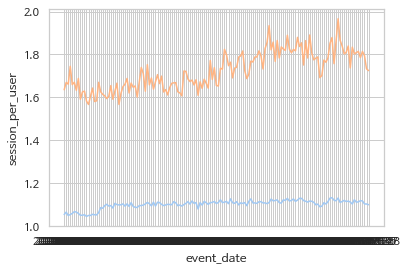

In [32]:
sns.lineplot(x='event_date', y='session_per_user', data=user_session_agg_df)
sns.lineplot(x='event_date', y='clicks_per_session', data=user_session_agg_df)

plt.show()

In [33]:
# melt 사용

melted_df = pd.melt(
    user_session_agg_df.reset_index(),
    id_vars=["event_date"],
    value_vars=["session_per_user", "clicks_per_session"]
)

melted_df.head()

,event_date,variable,value
0,2020-10-01,session_per_user,1.054835
1,2020-10-02,session_per_user,1.066041
2,2020-10-03,session_per_user,1.050416
3,2020-10-04,session_per_user,1.054629
4,2020-10-05,session_per_user,1.060028


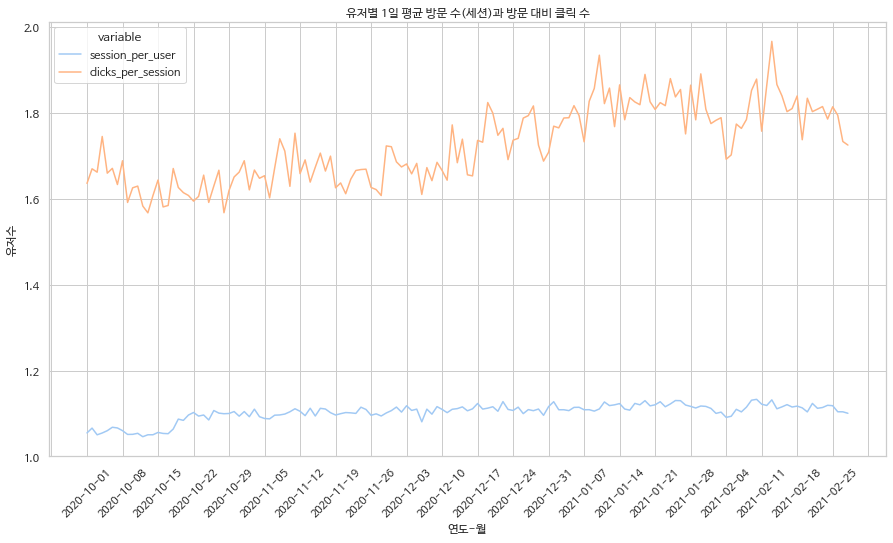

In [34]:
sns.set_theme( style="whitegrid", palette="pastel" )
plt.rc('font', family='NanumBarunGothic')
plt.xticks(rotation=45)

g = sns.lineplot(x="event_date", y="value", hue="variable", data=melted_df)
g.figure.set_size_inches(15, 8)


g.xaxis.set_major_locator(ticker.MultipleLocator(7))


g.set_title("유저별 1일 평균 방문 수(세션)과 방문 대비 클릭 수")
g.set_xlabel("연도-월")
g.set_ylabel("유저수")

plt.show()